# Planets Model

## Load Libs


In [1]:
import torch

torch.cuda.is_available()

True

In [2]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA not available. Checking why...")
    import os

    print(f"CUDA_VISIBLE_DEVICES: {os.environ.get('CUDA_VISIBLE_DEVICES', 'Not set')}")

PyTorch version: 2.5.1
CUDA available: True
CUDA version: 12.4
GPU device: NVIDIA GH200 480GB


In [3]:
import ast
import os
import re
from datetime import datetime as dt

import icecream
import numpy as np
import pandas as pd
import torch
from icecream import ic
from IPython.display import Image, display
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchviz import make_dot
from tqdm.notebook import tqdm
from transformers import BertTokenizerFast, BertModel

import hephaestus as hp
from hephaestus.analysis.plots import (
    evaluate_planetary_predictions,
    plot_training_history,
)
from hephaestus.models import TimeSeriesDecoder

# %%
torch.set_default_dtype(torch.float32)
# %%
icecream.install()
ic_disable = False  # Global variable to disable ic
if ic_disable:
    ic.disable()
ic.configureOutput(includeContext=True, contextAbsPath=True)
pd.options.mode.copy_on_write = True
os.environ["TOKENIZERS_PARALLELISM"] = "false"

2025-02-28 06:49:27.723782: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740725367.732092   16314 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740725367.735825   16314 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


We use BERT tokenizer to tokenize the text data.


In [4]:
model_name = "bert-base-uncased"
model = BertModel.from_pretrained(
    "bert-base-uncased", torch_dtype=torch.float32, attn_implementation="sdpa"
)
tokenizer = BertTokenizerFast.from_pretrained(model_name)

## Load Data

We use `line2df` to load the original data from
[PolyMathic](https://polymathic-ai.org/blog/xval/). Since we've already transformed the
data into a parquet file, we can load it directly.


In [5]:
def line2df(line, idx):
    data_rows = []
    line = ast.literal_eval(line)
    for i, time_step in enumerate(line["data"]):
        row = {"time_step": i}
        # Add position data for each planet
        for j, position in enumerate(time_step):
            row[f"planet{j}_x"] = position[0]
            row[f"planet{j}_y"] = position[1]
        data_rows.append(row)

    df = pd.DataFrame(data_rows)
    description = line.pop("description")
    step_size = description.pop("stepsize")
    for k, v in description.items():
        for k_prop, v_prop in v.items():
            df[f"{k}_{k_prop}"] = v_prop
    df["time_step"] = df["time_step"] * step_size
    df.insert(0, "idx", idx)

    return df

In [6]:
files = os.listdir("data")
if "planets.parquet" not in files:
    with open("data/planets.data") as f:
        data = f.read().splitlines()

        dfs = []
        for idx, line in enumerate(tqdm(data)):
            dfs.append(line2df(line, idx))
        df = pd.concat(dfs)
    df.to_parquet("data/planets.parquet")
else:
    df = pd.read_parquet("data/planets.parquet")


# Combine total mass of all planets into one column `planet<n>_m`
mass_regex = re.compile(r"planet(\d+)_m")
mass_cols = [col for col in df.columns if mass_regex.match(col)]
df["total_mass"] = df[mass_cols].sum(axis=1)
# Introduce categorical columns for the number of planets choose non null columns with mass
df["n_planets"] = df[mass_cols].notnull().sum(axis=1).astype("object")
df["n_planets"] = df["n_planets"].apply(lambda x: f"{x}_planets")
# Create category acceleration if the sum of plane/d_[x,y, z] is greater than 0
df["acceleration_x"] = df[
    [col for col in df.columns if "planet" in col and "_x" in col]
].sum(axis=1)
# Set acceleration_x to "increasing" if greater than 0 else "decreasing"
df["acceleration_x"] = (
    df["acceleration_x"]
    .apply(lambda x: "increasing" if x > 0 else "decreasing")
    .astype("object")
)
df["acceleration_y"] = df[
    [col for col in df.columns if "planet" in col and "_y" in col]
].sum(axis=1)
df["acceleration_y"] = df["acceleration_y"].apply(
    lambda x: "increasing" if x > 0 else "decreasing"
)


df.describe()

,idx,time_step,planet0_x,planet0_y,planet1_x,planet1_y,planet2_x,planet2_y,planet0_m,planet0_a,...,planet3_y,planet3_m,planet3_a,planet3_e,planet4_x,planet4_y,planet4_m,planet4_a,planet4_e,total_mass
count,5.563957e+06,5.563957e+06,5.563957e+06,5.563957e+06,5.563957e+06,5.563957e+06,4.165044e+06,4.165044e+06,5.563957e+06,5.563957e+06,...,2.783627e+06,2.783627e+06,2.783627e+06,2.783627e+06,1.392864e+06,1.392864e+06,1.392864e+06,1.392864e+06,1.392864e+06,5.563957e+06
mean,6.248635e+04,9.748911e+00,-1.339198e-01,7.391138e-02,-1.340140e-01,7.291389e-02,-1.305344e-01,7.065633e-02,2.999306e+00,1.624756e+00,...,6.559150e-02,2.996303e+00,1.623874e+00,9.980576e-01,-1.276881e-01,6.519469e-02,3.002531e+00,1.625815e+00,1.001317e+00,1.049149e+01
std,3.607949e+04,5.993534e+00,1.228071e+00,1.213232e+00,1.227950e+00,1.212650e+00,1.217229e+00,1.203678e+00,1.157182e+00,5.876632e-01,...,1.200148e+00,1.153190e+00,5.270725e-01,5.764675e-01,1.211648e+00,1.199625e+00,1.156856e+00,5.167198e-01,5.779763e-01,3.991780e+00
min,0.000000e+00,0.000000e+00,-3.294763e+00,-2.997514e+00,-3.284004e+00,-2.998546e+00,-3.289790e+00,-2.998050e+00,1.000003e+00,1.000000e+00,...,-2.997621e+00,1.000054e+00,1.000000e+00,9.369537e-05,-3.273603e+00,-2.998913e+00,1.000103e+00,1.000000e+00,6.720938e-05,2.014597e+00
25%,3.124400e+04,4.655172e+00,-1.030131e+00,-9.020907e-01,-1.030516e+00,-9.028009e-01,-1.050662e+00,-9.211662e-01,1.993948e+00,1.000000e+00,...,-9.321272e-01,1.996853e+00,1.191548e+00,4.980967e-01,-1.071974e+00,-9.394428e-01,2.004240e+00,1.215927e+00,5.032645e-01,7.282371e+00
50%,6.249100e+04,9.523810e+00,-1.542335e-01,1.117099e-01,-1.538916e-01,1.099474e-01,-1.525520e-01,1.118031e-01,2.994477e+00,1.543047e+00,...,1.067355e-01,3.001879e+00,1.535683e+00,9.955040e-01,-1.507184e-01,1.055276e-01,3.000454e+00,1.519040e+00,1.003118e+00,1.028205e+01
75%,9.372800e+04,1.440000e+01,8.583344e-01,9.784987e-01,8.581045e-01,9.783998e-01,8.762358e-01,9.912902e-01,4.005747e+00,2.020672e+00,...,9.956064e-01,3.986406e+00,1.969644e+00,1.497746e+00,8.906780e-01,9.991220e-01,4.003332e+00,1.950518e+00,1.503457e+00,1.345633e+01
max,1.249990e+05,2.400000e+01,2.996370e+00,2.999014e+00,2.993319e+00,2.999536e+00,2.990464e+00,2.998478e+00,4.999994e+00,2.999984e+00,...,3.000881e+00,4.999990e+00,2.999909e+00,1.999957e+00,2.985180e+00,2.998936e+00,4.999679e+00,2.999497e+00,1.999999e+00,2.382455e+01


In [7]:
df.head()

,idx,time_step,planet0_x,planet0_y,planet1_x,planet1_y,planet2_x,planet2_y,planet0_m,planet0_a,...,planet3_e,planet4_x,planet4_y,planet4_m,planet4_a,planet4_e,total_mass,n_planets,acceleration_x,acceleration_y
0,0,0.000000,1.560060,-0.854437,0.720639,0.691729,0.944008,2.700632,1.312562,1.944263,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974122,3_planets,increasing,increasing
1,0,0.465116,1.689858,-0.514359,0.333295,0.942289,0.681604,2.785811,1.312562,1.944263,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974122,3_planets,increasing,increasing
2,0,0.930233,1.753589,-0.154209,-0.124995,0.992368,0.412951,2.845461,1.312562,1.944263,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974122,3_planets,increasing,increasing
3,0,1.395349,1.748068,0.212022,-0.556775,0.831727,0.140540,2.879232,1.312562,1.944263,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974122,3_planets,increasing,increasing
4,0,1.860465,1.673573,0.569904,-0.870579,0.494812,-0.133144,2.887018,1.312562,1.944263,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974122,3_planets,increasing,increasing


In [8]:
df_categorical = df.select_dtypes(include=["object"]).astype(str)
unique_values_per_column = df_categorical.apply(
    pd.Series.unique
).values  # .flatten().tolist()
flattened_unique_values = np.concatenate(unique_values_per_column).tolist()
unique_values = list(set(flattened_unique_values))
unique_values

['3_planets',
 '2_planets',
 'decreasing',
 'increasing',
 '5_planets',
 '4_planets']

In [9]:
df.select_dtypes(include="object").groupby(
    df.select_dtypes(include="object").columns.tolist()
).size().reset_index(name="count")

,n_planets,acceleration_x,acceleration_y,count
0,2_planets,decreasing,decreasing,365720
1,2_planets,decreasing,increasing,410992
2,2_planets,increasing,decreasing,272240
3,2_planets,increasing,increasing,349961
4,3_planets,decreasing,decreasing,410092
5,3_planets,decreasing,increasing,404513
6,3_planets,increasing,decreasing,258536
7,3_planets,increasing,increasing,308276
8,4_planets,decreasing,decreasing,413451
9,4_planets,decreasing,increasing,416444


In [10]:
df = df.reset_index(drop=True)
# df = df.head(
#     5_000
# )  # For testing purposes only, train on the full dataset in production

In [11]:
# Get train test split at 80/20
time_series_config = hp.TimeSeriesConfig.generate(df=df)
train_idx = int(df.idx.max() * 0.8)
train_df = df.loc[df.idx < train_idx].copy()
test_df = df.loc[df.idx >= train_idx].copy()
# del df
train_ds = hp.TimeSeriesDS(train_df, time_series_config)
test_ds = hp.TimeSeriesDS(test_df, time_series_config)
len(train_ds), len(test_ds)

(99999, 25001)

In [12]:
N_HEADS = 8 * 4
tabular_decoder = TimeSeriesDecoder(time_series_config, d_model=512, n_heads=N_HEADS)

In [ ]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

batch_size = 32

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,  # Set to 0 to avoid multiprocessing issues
    collate_fn=hp.tabular_collate_fn,
    pin_memory=True if torch.cuda.is_available() else False,
)
tabular_decoder = tabular_decoder.to(device)  # Move model to device first

# Create a sample batch from the training dataset
example_batch = train_ds[0:6]
numeric_data = example_batch.numeric.to(device)
categorical_data = example_batch.categorical.to(device)

Using device: cuda


In [14]:
with torch.no_grad():
    prediction = tabular_decoder(numeric_data, categorical_data)

    # Move predictions back to CPU for numpy operations if needed
    prediction = prediction.to("cpu")

    prediction.numeric = prediction.numeric.transpose(1, 2)
    prediction.categorical = prediction.categorical.permute(0, 2, 1, 3)


# Print prediction summary instead of all values
print("Prediction numeric shape:", prediction.numeric.shape)
print("Prediction categorical shape:", prediction.categorical.shape)
print(
    "Prediction contains NaN (numeric):",
    torch.isnan(prediction.numeric).any().item(),
)
print(
    "Prediction contains NaN (categorical):",
    torch.isnan(prediction.categorical).any().item(),
)

ic| /home/ubuntu/industrytransformer/Hephaestus/hephaestus/models/models.py:538 in forward()
    numeric_inputs.shape: torch.Size([6, 27, 59])
    categorical_inputs.shape: torch.Size([6, 3, 59])
ic| /home/ubuntu/industrytransformer/Hephaestus/hephaestus/models/models.py:327 in process_numeric()
    "col_token type": 'col_token type'
    numeric_col_embeddings.dtype: torch.float32
ic| /home/ubuntu/industrytransformer/Hephaestus/hephaestus/models/models.py:335 in process_numeric()
    numeric_embedding.shape: torch.Size([512])
ic| /home/ubuntu/industrytransformer/Hephaestus/hephaestus/models/models.py:339 in process_numeric()
    numeric_embedding.shape: torch.Size([6, 27, 59, 512])
ic| /home/ubuntu/industrytransformer/Hephaestus/hephaestus/models/models.py:358 in process_numeric()
    numeric_embedding.shape: torch.Size([6, 27, 59, 512])
ic| /home/ubuntu/industrytransformer/Hephaestus/hephaestus/models/models.py:404 in process_categorical()
    "Issue here": 'Issue here'
    categorica

Prediction numeric shape: torch.Size([6, 59, 27])
Prediction categorical shape: torch.Size([6, 59, 3, 41])
Prediction contains NaN (numeric): False
Prediction contains NaN (categorical): False


In [15]:
ic.disable()

TensorBoard logs will be saved to: runs/2025-02-28T06-49-43_Heads_32_Batch_256
To view logs, run: tensorboard --logdir=runs
Using device: cuda
TensorBoard log directory: runs/2025-02-28T06-49-43_Heads_32_Batch_256
Epoch 1/2


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Validation:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 1/2 completed in 625.75s
Train Loss: 3.8434, Val Loss: 1.8828
Train Numeric Loss: 1.6033, Val Numeric Loss: 0.4858
Train Cat Loss: 2.2401, Val Cat Loss: 1.3970
Current learning rate: 1.00e-04
--------------------------------------------------
Epoch 2/2


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Validation:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 2/2 completed in 624.48s
Train Loss: 1.4855, Val Loss: 1.3850
Train Numeric Loss: 0.3228, Val Numeric Loss: 0.2847
Train Cat Loss: 1.1627, Val Cat Loss: 1.1003
Current learning rate: 1.00e-04
--------------------------------------------------
Training completed! TensorBoard logs saved to runs/2025-02-28T06-49-43_Heads_32_Batch_256
To view training metrics, run:
tensorboard --logdir=runs


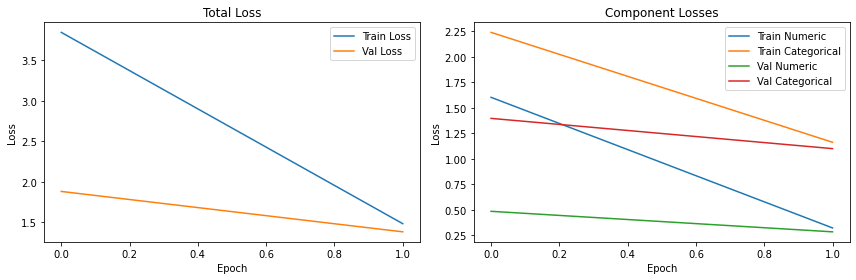

/tmp/ipykernel_16314/2387580294.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path, map_location=device)


Loaded best model from epoch 1 with validation loss 1.3850

=== Evaluating Model Predictions on Sample Data ===

Creating auto-regressive predictions...
Generating predictions for next 20 steps...
  Step 1 completed
  Step 6 completed
  Step 11 completed
  Step 16 completed

Processing results...

=== Comparison of Predicted vs Actual Values ===

Mean Absolute Error for Planet Positions:
Valid MAE calculations: 8/10 columns
Columns with invalid values: planet4_x, planet4_y
planet0_x: 1.588689
planet0_y: 1.463294
planet1_x: 1.704571
planet1_y: 2.856852
planet2_x: 1.000959
planet2_y: 1.132683
planet3_x: 0.870685
planet3_y: 0.980955
planet4_x: N/A (non-finite values)
planet4_y: N/A (non-finite values)

MAE Statistics:
Mean: 1.449836
Median: 1.297989
Min: 0.870685
Max: 2.856852
Std: 0.604296

Generating plots for planet positions...


/home/ubuntu/industrytransformer/Hephaestus/hephaestus/analysis/plots.py:386: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(actuals.numeric), torch.tensor(actuals.categorical)



Calculating position error over time...


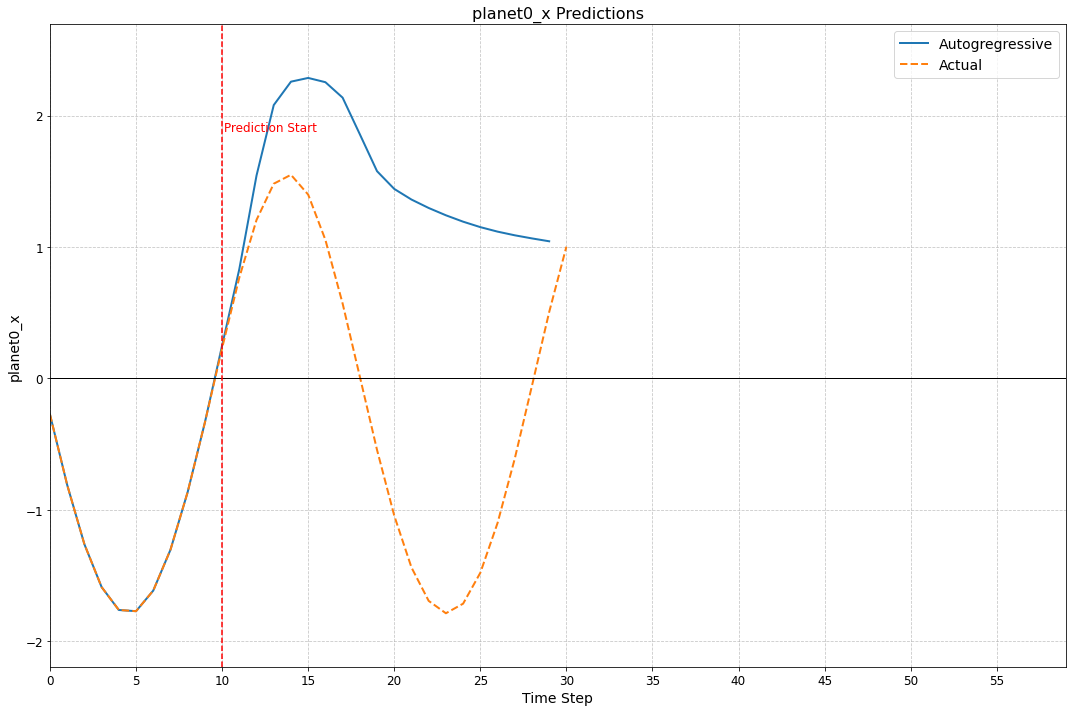

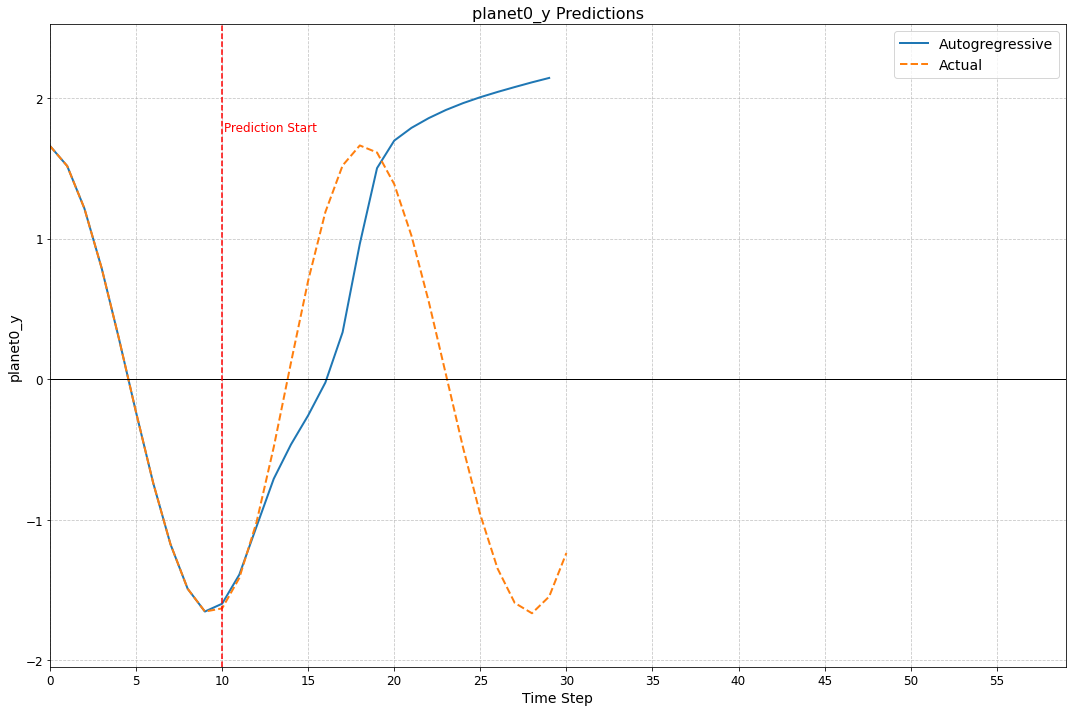

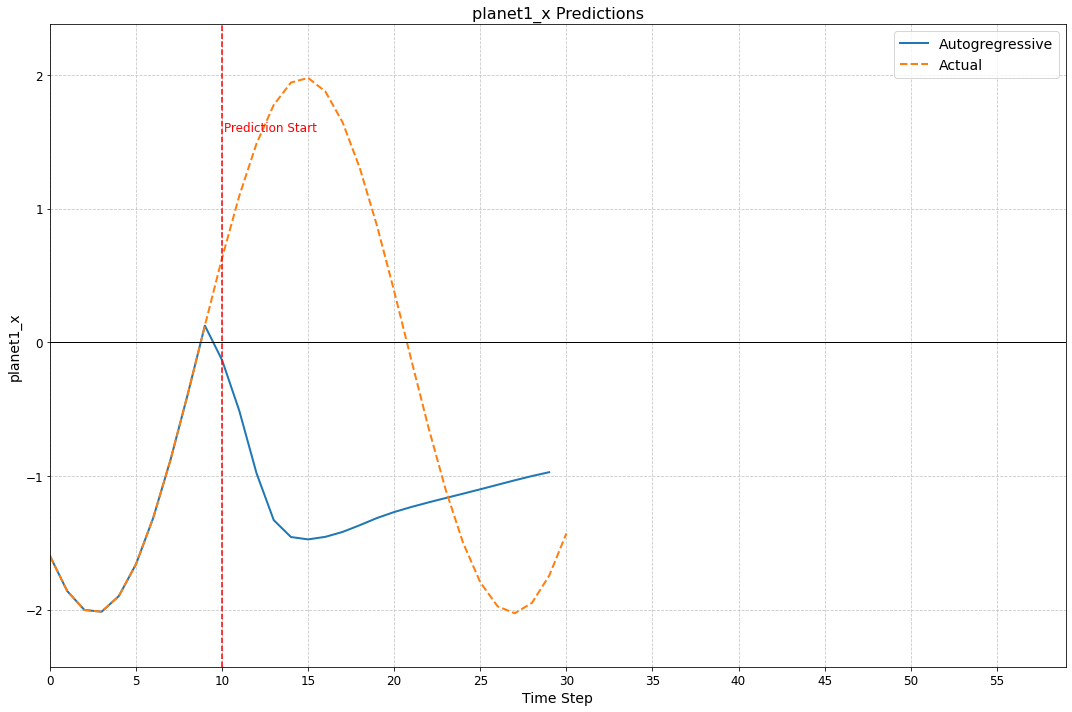

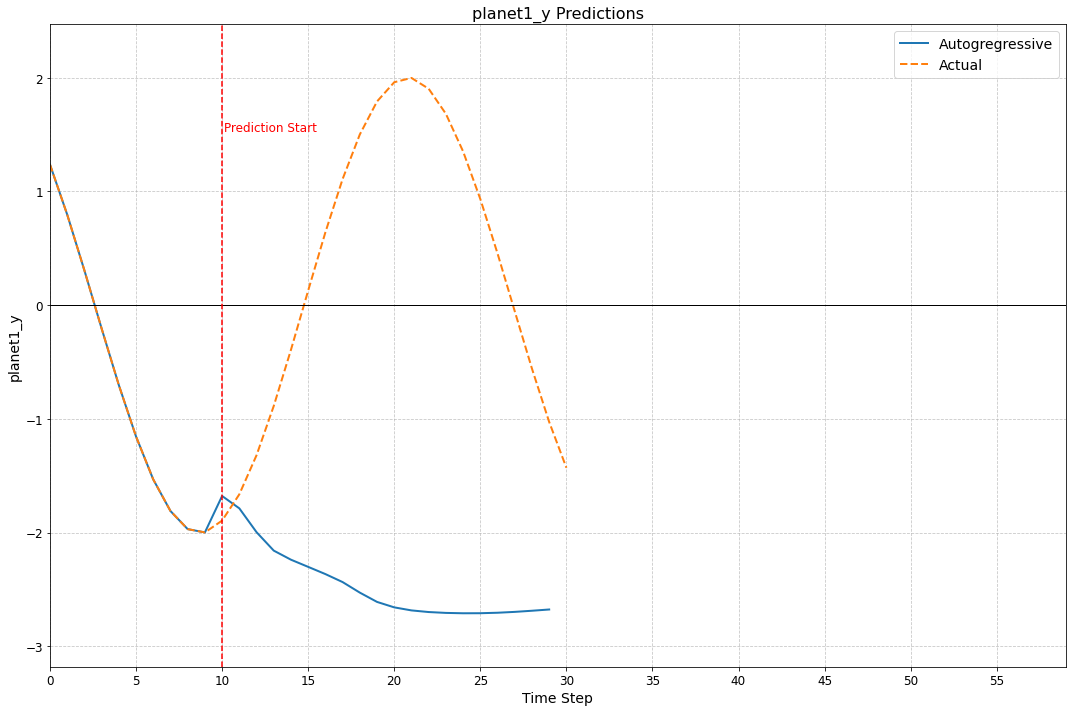

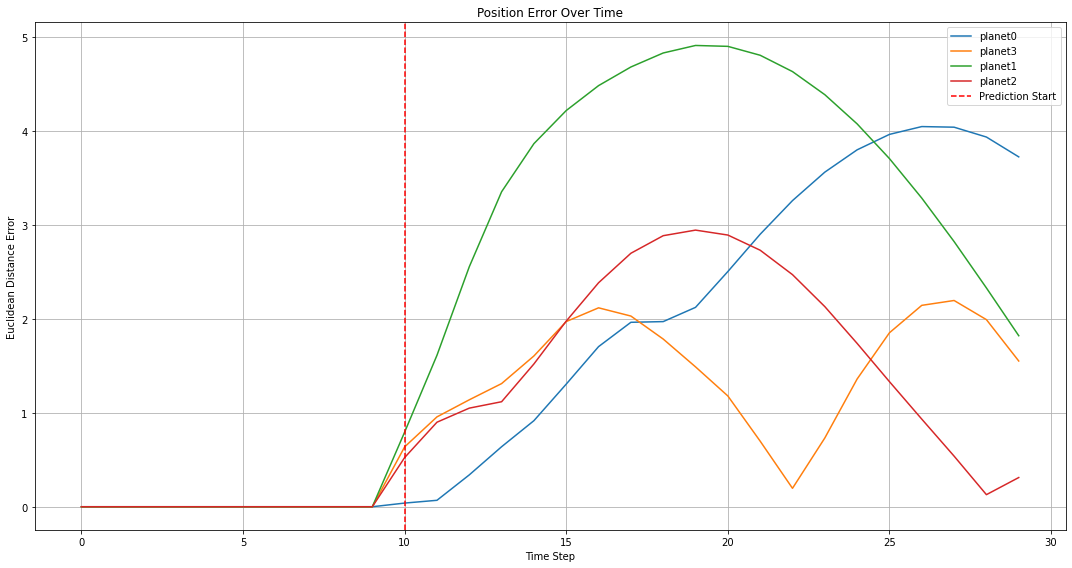

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Average Position Error (excluding input period):
planet4: No valid error values
planet0: 2.342270
planet3: 1.448341
planet1: 3.606590
planet2: 1.661731

Generating planetary trajectory comparison plots...


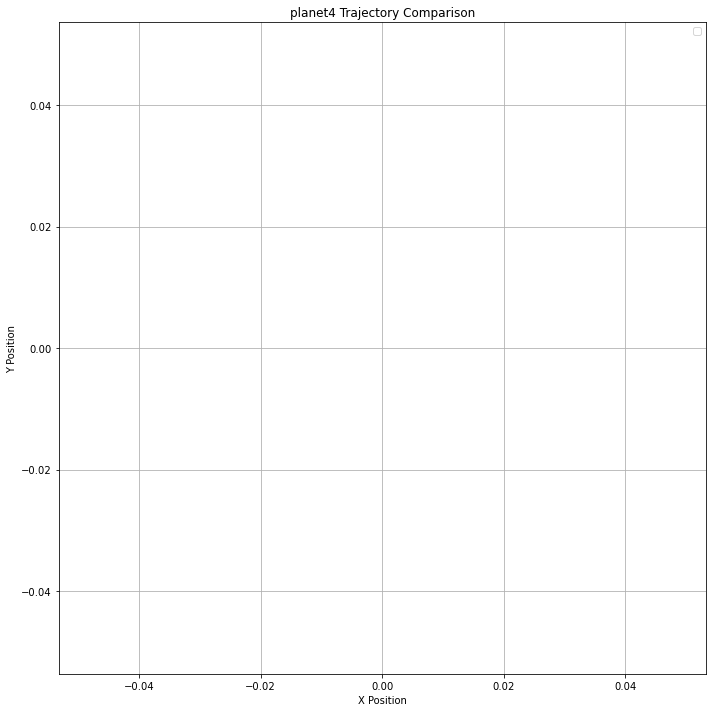


Error during evaluation: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

Skipping detailed evaluation due to error.


Traceback (most recent call last):
  File "/home/ubuntu/industrytransformer/Hephaestus/hephaestus/analysis/plots.py", line 546, in evaluate_planetary_predictions
    plot_planet_trajectory(pred_df, actual_df, planet_id, save_dir)
  File "/home/ubuntu/industrytransformer/Hephaestus/hephaestus/analysis/plots.py", line 197, in plot_planet_trajectory
    safe_plot(
  File "/home/ubuntu/industrytransformer/Hephaestus/hephaestus/analysis/plots.py", line 62, in safe_plot
    return plt.plot(x, y, *args, **kwargs)
  File "/usr/lib/python3/dist-packages/matplotlib/pyplot.py", line 2757, in plot
    return gca().plot(
  File "/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py", line 1632, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
  File "/usr/lib/python3/dist-packages/matplotlib/axes/_base.py", line 312, in __call__
    yield from self._plot_args(this, kwargs)
  File "/usr/lib/python3/dist-packages/matplotlib/axes/_base.py", line 487, in _plot_args
    x = _check_1d

{'train_loss': [3.8433734135859456, 1.4855237040678253],
 'train_numeric_loss': [1.6032625021379623, 0.32280289879083024],
 'train_categorical_loss': [2.2401109192987234, 1.1627208070681834],
 'val_loss': [1.8827814630099706, 1.3849879442429056],
 'val_numeric_loss': [0.485820936913393, 0.28465556550999077],
 'val_categorical_loss': [1.3969605224473136, 1.1003323756918615]}

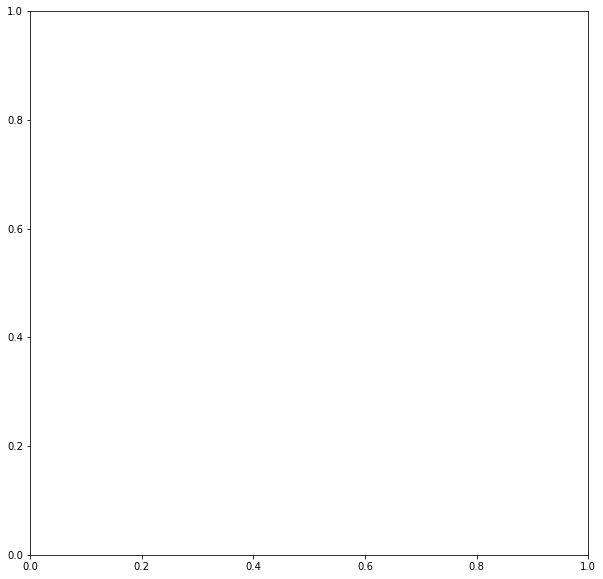

In [16]:
def init_weights(m):
    if hasattr(m, "weight") and m.weight is not None:
        if len(m.weight.shape) > 1:
            # Use Kaiming initialization for better stability
            torch.nn.init.kaiming_normal_(m.weight, mode="fan_in", nonlinearity="relu")
            # Scale down initial weights to prevent explosions
            m.weight.data *= 0.05
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.zeros_(m.bias)


# Apply custom weight initialization
tabular_decoder.apply(init_weights)
# print("Applied conservative weight initialization")

# Move model to device
tabular_decoder.to(device)

# Set up training parameters with much more conservative values
learning_rate = 1e-3  # Reduced learning rate by 5x
num_epochs = 2
gradient_accumulation_steps = 4  # Increased for stability
max_grad_norm = 0.1  # Much tighter gradient clipping

# Add gradient explosion detection threshold
max_gradient_norm_allowed = 10.0
max_explosion_count = 5  # Allow this many explosions before reducing LR permanently

timestamp = dt.now().strftime("%Y-%m-%dT%H-%M-%S")
log_dir = f"runs/{timestamp}_Heads_{N_HEADS}_Batch_{batch_size}"
save_dir = "images/planets"

# Ensure log directory exists
os.makedirs(log_dir, exist_ok=True)
os.makedirs(save_dir, exist_ok=True)
print(f"TensorBoard logs will be saved to: {log_dir}")
print("To view logs, run: tensorboard --logdir=runs")
writer = SummaryWriter(log_dir)
# Train the model with enhanced stability parameters
history = hp.train_model(
    model=tabular_decoder,
    train_dataset=train_ds,
    val_dataset=test_ds,
    batch_size=batch_size,  # Reduced batch size for stability
    epochs=num_epochs,
    learning_rate=learning_rate,
    log_dir=log_dir,
    save_dir=save_dir,
    device=device,
    gradient_accumulation_steps=gradient_accumulation_steps,
    max_grad_norm=max_grad_norm,
    explosion_threshold=max_gradient_norm_allowed,
    max_explosions_per_epoch=max_explosion_count,
    writer=writer,
)

# Import the plotting functions from our new module

# Visualize training history
plot_training_history(history, save_dir)

# Load best model for evaluation
best_model_path = os.path.join(save_dir, "best_model.pt")
if os.path.exists(best_model_path):
    checkpoint = torch.load(best_model_path, map_location=device)
    tabular_decoder.load_state_dict(checkpoint["model_state_dict"])
    print(
        f"Loaded best model from epoch {checkpoint['epoch']} with validation loss {checkpoint['val_loss']:.4f}"
    )

    # Evaluate the model on the test data using our new function
    try:
        results, pred_df, actual_df = evaluate_planetary_predictions(
            model=tabular_decoder,
            test_ds=test_ds,
            time_series_config=time_series_config,
            test_sample_idx=0,
            n_steps=20,
            save_dir=save_dir,
            device=device,
        )

        # Print summary of evaluation results with better NaN handling
        if results and "mae_results" in results:
            # Filter out NaN values before calculating average
            valid_maes = [v for v in results["mae_results"].values() if np.isfinite(v)]

            if valid_maes:
                avg_mae = sum(valid_maes) / len(valid_maes)
                print(
                    "\nEvaluation complete. Average MAE across all positions:",
                    f"{avg_mae:.6f}",
                )
                print(
                    f"Valid MAE values: {len(valid_maes)}/{len(results['mae_results'])}"
                )
            else:
                print("\nEvaluation complete, but no valid MAE values were found.")
                print("Check for numerical stability issues in your model predictions.")

    except Exception as e:
        print(f"Error during evaluation: {e}")

history

In [17]:
# Create a wrapper model that converts the TimeSeriesOutput to regular tensors


class ModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, numeric_input, categorical_input):
        output = self.model(numeric_input, categorical_input)
        # Return a tuple of tensors instead of TimeSeriesOutput object
        return output.numeric, output.categorical


# Create a new SummaryWriter
model_writer = SummaryWriter(log_dir + "/model_graph")

with torch.no_grad():
    # Wrap the model
    wrapped_model = ModelWrapper(tabular_decoder)

    # Move to the same device
    wrapped_model = wrapped_model.to(device)
    numeric_sample = numeric_data
    categorical_sample = categorical_data

    # Add the wrapped model to tensorboard
    try:
        model_writer.add_graph(wrapped_model, (numeric_sample, categorical_sample))
        print("Model graph added successfully")
    except Exception as e:
        print(f"Failed to add model graph: {e}")

# Make sure it's written to disk
model_writer.flush()
model_writer.close()
writer.close()

/home/ubuntu/industrytransformer/Hephaestus/hephaestus/models/models.py:661: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if torch.isnan(numeric_inputs).any():
/home/ubuntu/industrytransformer/Hephaestus/hephaestus/models/models.py:329: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  torch.tensor(
/home/ubuntu/industrytransformer/Hephaestus/hephaestus/models/models.py:342: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to crea

Model graph added successfully


In [18]:
# Create a more focused visualization
with torch.no_grad():
    output = tabular_decoder(numeric_data, categorical_data)

    # Create a reduced-complexity visualization
    dot = make_dot(
        (output.numeric.sum(), output.categorical.sum()),
        params=dict(tabular_decoder.named_parameters()),
        show_attrs=False,  # Hide attributes to reduce clutter
        show_saved=False,  # Hide saved variables
    )

    # Configure for better readability
    dot.attr(rankdir="LR")
    dot.attr("graph", ratio="0.7")  # Adjust aspect ratio
    dot.attr("node", shape="box", style="filled", fillcolor="lightblue")

    # For better JPG quality    # If you want an interactive HTML visualization
    with torch.no_grad():
        output = tabular_decoder(numeric_data, categorical_data)
        dot = make_dot(
            (
                output.numeric.mean(),
                output.categorical.mean(),
            ),  # Using mean instead of sum for variety
            params=dict(tabular_decoder.named_parameters()),
            show_attrs=False,
        )

        # Generate HTML
        from IPython.display import HTML

        html_path = f"{save_dir}/model_graph.html"

        # Set format to svg for interactive elements
        dot.format = "svg"
        dot.render(html_path)

        # Display the SVG directly
        with open(f"{html_path}.svg") as f:
            svg_content = f.read()
            display(HTML(svg_content))
    graph_path = f"{save_dir}/model_graph_simplified"
    dot.format = "png"
    dot.render(graph_path)

    # Display with a specified size
    display(Image(filename=f"{graph_path}.png", width=1000, height=800))

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH